<a href="https://colab.research.google.com/github/Sakshamgoel/Genre-Classification/blob/develop/Multiclassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install langdetect

In [ ]:
import json, langdetect, copy, requests

url = 'https://raw.githubusercontent.com/Sakshamgoel/Genre-Classification/develop/datasets/songs_w_lyrics.json'
resp = requests.get(url)
songs = json.loads(resp.text)

song_lens = {}
max_len = -1
songs_combined = {}


for g in songs:
    if g == 'Rock':
        songs_combined['Rock/Pop'] = songs[g]
    elif g == 'Pop':  
        songs_combined['Rock/Pop'] += songs[g]
    else:
        songs_combined[g] = songs[g]

songs = copy.deepcopy(songs_combined)

for g in songs:
    for t in songs[g]:
        lang = langdetect.detect(t[2].strip()) 
        if (lang != 'en'):
            songs[g].remove(t)
            continue

for g in songs:
    if len(songs[g]) > max_len:
        max_len = len(songs[g])
    song_lens[g] = len(songs[g])    

for g in songs:
    c = 0
    while (len(songs[g]) != max_len):
        if (c == song_lens[g]):
            c = 0
        songs[g].append(songs[g][c])
        c += 1
songs_combined = None

for g in songs:
    print(len(songs[g]))

1730
1730
1730
1730
1730
1730
1730
1730


In [ ]:
import pandas as pd

df = {'artist':[], 'song':[], 'lyrics':[], 'genre':[]}

for g in songs:
    for song in songs[g]:
        df['artist'].append(song[0])
        df['song'].append(song[1])
        df['lyrics'].append(song[2])
        df['genre'].append(g)

df = pd.DataFrame(df)
df.head()

,artist,song,lyrics,genre
0,Paralyzed,Sueco,"She got a big ego, you could see it on a teles...",Rock/Pop
1,Kill The Noise,Papa Roach,I just feel like I'm channeling something\nKil...,Rock/Pop
2,Don’t Back Down,Mammoth WVH,Breathe it in\nAll the madness around you\nFee...,Rock/Pop
3,Wake Me Up,Foals,Wake me up\nWake me up\n\nI'm walking through ...,Rock/Pop
4,"deathwish (feat. nothing,nowhere.)",Stand Atlantic,You make my head spin\nGod knows I can't win\n...,Rock/Pop


In [ ]:
from io import StringIO
col = ['genre', 'lyrics']
df = df[col]
df = df[pd.notnull(df['lyrics'])]
df.columns = ['genre', 'lyrics']
df['category_id'] = df['genre'].factorize()[0]
category_id_df = df[['genre', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'genre']].values)
df.head()

,genre,lyrics,category_id
0,Rock/Pop,"She got a big ego, you could see it on a teles...",0
1,Rock/Pop,I just feel like I'm channeling something\nKil...,0
2,Rock/Pop,Breathe it in\nAll the madness around you\nFee...,0
3,Rock/Pop,Wake me up\nWake me up\n\nI'm walking through ...,0
4,Rock/Pop,You make my head spin\nGod knows I can't win\n...,0


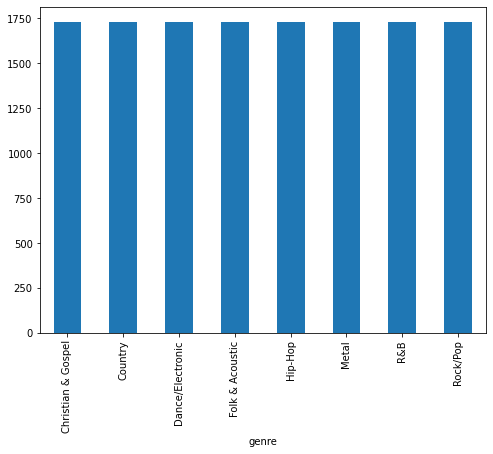

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
df.groupby('genre').lyrics.count().plot.bar(ylim=0)
plt.show()

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
features = tfidf.fit_transform(df.lyrics)
labels = df.category_id

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

X_train, X_test, y_train, y_test = train_test_split(df['lyrics'], df['genre'], random_state = 42)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
clf = MultinomialNB().fit(X_train_tfidf, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


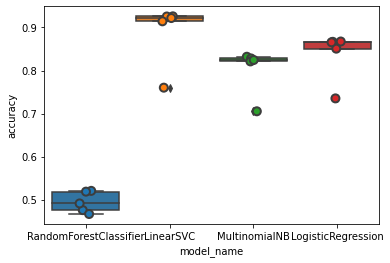

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]

CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

import seaborn as sns
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [ ]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.889595
LogisticRegression        0.837139
MultinomialNB             0.802168
RandomForestClassifier    0.494292
Name: accuracy, dtype: float64

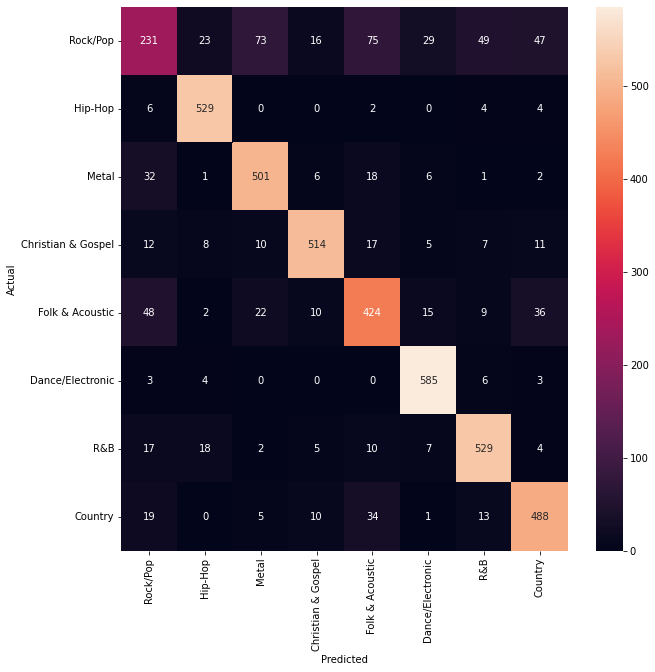

In [ ]:
model = LinearSVC()
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.33, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
xticklabels=category_id_df.genre.values, yticklabels=category_id_df.genre.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

print("Precision: ", precision_score(y_test, y_pred, average='micro'))
print("Recall: ", recall_score(y_test, y_pred, average='micro'))
print("F1: ", f1_score(y_test, y_pred, average='micro'))

Precision:  0.832092819614711
Recall:  0.832092819614711
F1:  0.832092819614711


In [ ]:
import pickle

with open('/content/gdrive/My Drive/Programming/SVC.sav', 'wb') as f:
    pickle.dump(model, f)

FileNotFoundError: ignored